In [3]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # blacklist tf warning and info

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import h5py

In [5]:
def get_model_path(config, use_batch_norm = False):
    if use_batch_norm:
        batch_norm_str = 'batch_norm'
    else:
        batch_norm_str = 'no_batch_norm'
    return 'weights/window_{}/{}/checkpoint.ckpt'.format(window_length, batch_norm_str)

In [6]:
from environment.portfolio import PortfolioEnv

In [7]:
eps=1e-8

In [8]:
abbreviations = ['AAPL.O',
                 'ADBE.O',
                 'AMZN.O',
                 'DIS.N',
                 'GOOGL.O',
                 'JNJ.N',
                 'JPM.N',
                 'MSFT.O',
                 'NFLX.O',
                 'PG.N']

In [9]:
import json
with open('configs/ddpg_default.json') as f:
    config = json.load(f)

In [10]:
with h5py.File('./Data/history_stock_price.h5','r') as f:
    history_stock_price = f['stock_price'][...]
    timestamp = [s.decode('utf-8') for s in f['timestamp']]
    abbreviations = [s.decode('utf-8') for s in f['abbreviations']]
    features = [s.decode('utf-8') for s in f['features']]

In [11]:
train_step = timestamp.index('2020-01-02')
valid_step = timestamp.index('2020-07-01')

In [12]:
history_stock_price_training = history_stock_price[:,:train_step,:]
history_stock_price_validating = history_stock_price[:,train_step:valid_step,:]
history_stock_price_testing = history_stock_price[:,valid_step:,:]
timestamp_training = timestamp[:train_step]
timestamp_validating = timestamp[train_step:valid_step]
timestamp_testing = timestamp[valid_step:]

In [13]:
env_training = PortfolioEnv(history=history_stock_price_training,
                                abbreviation=abbreviations,
                                timestamp=timestamp_training,
                                steps=3000)

In [14]:
env_validating = PortfolioEnv(history=history_stock_price_validating,
                                abbreviation=abbreviations,
                                timestamp=timestamp_validating,
                                steps=50)

# DDPG

In [15]:
tf.reset_default_graph()

In [16]:
from model.ddpg.stockactor import StockActor
from model.ddpg.stockcritic import StockCritic
from model.ddpg.ddpg import DDPG
from model.core.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise

In [17]:
actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(config['input']['asset_number']+1))

In [18]:
sess = tf.Session()
stockactor = StockActor(sess, config, action_bound=1)
stockcritic = StockCritic(sess, config, num_actor_vars=stockactor.get_num_trainable_vars())


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.



In [19]:
myddpg_training = DDPG(env_training,sess,stockactor,critic=stockcritic,
              actor_noise=actor_noise, config=config)

In [20]:
myddpg_training.initialize(load_weights=False)  # change to True to load weights

Build model from scratch



In [21]:
myddpg_training.train()


Start date: 2005-10-10
Episode: 0, Reward: 1.00, Qmax: 0.2553
Start date: 2007-11-15
Episode: 1, Reward: 0.74, Qmax: 0.1689
Start date: 2005-10-28
Episode: 2, Reward: 1.13, Qmax: 0.1533
Start date: 2006-12-27
Episode: 3, Reward: 0.72, Qmax: 0.1541
Start date: 2006-05-18
Episode: 4, Reward: 0.75, Qmax: 0.1544
Start date: 2006-05-10
Episode: 5, Reward: 0.52, Qmax: 0.1526
Start date: 2007-03-20
Episode: 6, Reward: 0.48, Qmax: 0.1514
Start date: 2005-07-18
Episode: 7, Reward: 0.87, Qmax: 0.1516
Start date: 2006-04-27
Episode: 8, Reward: 0.92, Qmax: 0.1518
Start date: 2007-03-22
Episode: 9, Reward: 0.94, Qmax: 0.1510

Model saved in weights/ddpg/ddpg.ckpt
Finish.


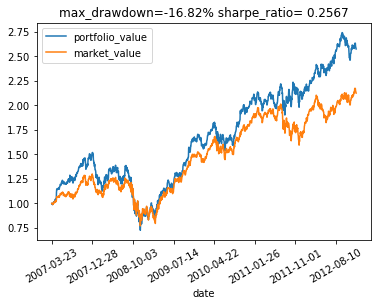

In [22]:
env_training.render()

# Testing

In [ ]:
myddpg_training.initialize(load_weights=True)

In [51]:
pre_obs, ground_truth_obs = env_validating.reset()
w = myddpg_training.predict(np.expand_dims(pre_obs,axis=0)).squeeze(axis=0)
done = False
while not done:
    obs, onestep_r, done, info = env_validating.step(w)
    w = myddpg_training.predict(np.expand_dims(obs,axis=0)).squeeze(axis=0)

Start date: 2020-03-24


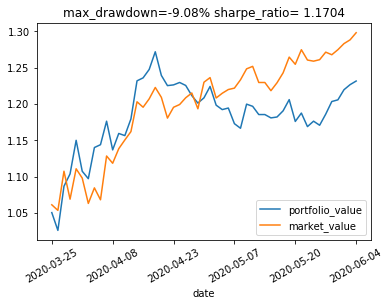

In [52]:
env_validating.render()

# Random Stratety on Validation set

In [53]:
pre_obs, ground_truth_obs = env_validating.reset()
done = False
while not done:
    observation, onestep_r, done, info = env_validating.step(np.random.rand(11))

Start date: 2020-04-06


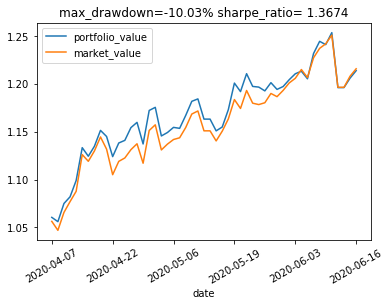

In [54]:
env_validating.render()